In [2]:
import igl # Library to load meshes and perform operations on them
import os # Library to perform operations on files and directories
import meshplot as mp # Library to visualize meshes and point clouds
import numpy as np
import matplotlib.pyplot as plt
import polyscope as ps # Library to visualize meshes

dir_path = os.getcwd()
rng = np.random.default_rng()

Our energy for the point $P \in \mathbb{R^3}$ is
$$
E_{\text{angle sum}} = \sum_{v \in V}||\frac{(P - v)}{||P - v||}\cdot n_{v} - 1 + \mu_1^2||^2 + ||\frac{(P - v)}{||P - v||}\cdot n_{v} - 0.7 - \mu_2^2||^2
$$
$$
\partial_P\left(\frac{(P - v)}{||P - v||}\cdot n_{v} - 1 + \mu_1^2\right) = \frac{1}{||P - v||}n_v
$$
$$
\partial_{\mu_1}\left(\frac{(P - v)}{||P - v||}\cdot n_{v} - 1 + \mu_1^2\right) = 2\mu_1
$$
$$
\partial_P\left(\frac{(P - v)}{||P - v||}\cdot n_{v} - 0.7 - \mu_2^2\right) = \frac{1}{||P - v||}n_v
$$
$$
\partial_{\mu_2}\left(\frac{(P - v)}{||P - v||}\cdot n_{v} - 0.7 - \mu_2^2\right) = -2\mu_2
$$


In [4]:
#Objs/mid_surf_smms_opt.obj - saddle
#Objs/obj_hex/dome1_tri_op.obj - building
#Objs/obj_equilibrium/tri_mesh.obj - hyperboloid
v, f = igl.read_triangle_mesh("C:/Users/aikyna/Desktop/hananLab/hJupyter/models/Hall.obj")
V = len(v) # Number of vertices
F = len(f) # Number of faces

v1, v2, k1, k2 = igl.principal_curvature(v, f)
normals = igl.per_vertex_normals(v, f)
v_focal1 = np.zeros((V, 3))
v_focal2 = np.zeros((V, 3))
point = np.zeros(3)
for v_ind in range(V):
    point += (v[v_ind] + normals[v_ind] * (1 / k2[v_ind]))
    if (k1[v_ind] != 0):
        v_focal1[v_ind] = v[v_ind] + normals[v_ind] / k1[v_ind]
    if (k2[v_ind] != 0):
        v_focal2[v_ind] = v[v_ind] + normals[v_ind] / k2[v_ind]
    #point += v[v_ind] 
point /= V

print(np.max(v_focal1))
print(np.min(np.absolute(v_focal1)))
p = mp.plot(v, f, return_plot=True)
p

J = np.zeros((2 * V, 3 + 2 * V))
r = np.zeros(2 * V)

2000800.2731152833
0.0004395949481104111


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(19.867670…

In [100]:
# Initialize polyscope
ps.init()


### Register a mesh
# `verts` is a Nx3 numpy array of vertex positions
# `faces` is a Fx3 array of indices, or a nested list
ps.register_surface_mesh("Mesh", v, f, smooth_shade=True)

#ps.register_surface_mesh("Dual", bar, dual, smooth_shade=True)

# Add a scalar function and a vector function defined on the mesh
# vertex_scalar is a length V numpy array of values
# face_vectors is an Fx3 array of vectors per face


# View the point cloud and mesh we just registered in the 3D UI
ps.show()


In [3]:
def compute_J(v, f, normals, X, p_length):
    # Hint: consider the first 4 rows of the J matrix 
    # as the ones related to the first sum and the last rows related to the second sum
    for v_ind in range(V):
        point = X[0:3]
        mu1 = X[3 + 2 * v_ind]
        mu2 = X[3 + 2 * v_ind + 1]
    
        # Edge constraint (c-v)*n_f - 1 + (\mu_1)^2 = 0
        J[v_ind, 0:3] = normals[v_ind] / p_length[v_ind]
        J[v_ind, 3 + 2 * v_ind] = 2.0 * mu1

        # Edge constraint nf(v2 - v1) = 0
        J[V + v_ind, 0:3] = normals[v_ind]/p_length[v_ind]
        J[V + v_ind, 3 + 2 * v_ind + 1] =  -2.0 * mu2

        r[v_ind] = np.dot(point - v[v_ind], normals[v_ind]) / p_length[v_ind] - 1 + mu1 * mu1
        r[V + v_ind] = np.dot(point - v[v_ind], normals[v_ind]) / p_length[v_ind] - 0.7 - mu2 * mu2
        p_length[v_ind] = np.linalg.norm(point - v[v_ind])

In [1]:
X_0 = np.concatenate((point, np.random.rand(2*V)))
p_length = np.zeros(V)

NameError: name 'np' is not defined

In [5]:
from scipy.sparse import csr_matrix, csc_matrix, coo_matrix, linalg

# Compute pseudo Hessian
X = X_0
for v_ind in range(V):
    p_length[v_ind] = np.linalg.norm(point - v[v_ind])
print(point, v[0])
print(p_length[0])
for i in range(30):
    compute_J(v, f, normals, X, p_length)    

    H = J.T@J

    H[np.diag_indices_from(H)] += np.diag(H).max()*1e-6

    # Sparse matrix H
    H = csc_matrix(H)

    # Solve for dx
    dx = linalg.spsolve(H, -J.T@r)
    # Update vertices
    X = X + 0.7*dx
    
    # energy
    energy = r.T@r
    print(f"energy: {energy}\t dx: {np.linalg.norm(dx)}")



[15.00803372 26.08616725 -3.02207594] [8.147727 8.511167 5.435742]
20.675568350110648
energy: 935.4508755590022	 dx: 155.1443980208525
energy: 4605941.560612577	 dx: 55.046473283686
energy: 822155.3898042911	 dx: 37.41313508131939
energy: 146696.22546038622	 dx: 26.790179444058715
energy: 26400.863304420323	 dx: 21.88089815103454
energy: 5240.147685408456	 dx: 21.83065067668008
energy: 2342.3189272503714	 dx: 20.31063063925021
energy: 1981.5762275408733	 dx: 18.638559697553504
energy: 1580.8804385660203	 dx: 15.575259778373418
energy: 724.3385492050638	 dx: 18.298310851117773
energy: 2985.8861221688594	 dx: 13.325716201574663
energy: 764.101560325117	 dx: 19.34678377152339
energy: 2467.0191448294786	 dx: 17.39316465477379
energy: 1603.1234276694659	 dx: 15.097524375941383
energy: 1177.8139502776874	 dx: 13.12319202722285
energy: 784.389480539239	 dx: 10.73454468840639
energy: 257.54674985546393	 dx: 18.59036794076693
energy: 2166.5944800740817	 dx: 10.724442061140632
energy: 480.936916

In [6]:
p = mp.plot(v, f, return_plot=True)
point = X[0:3]
print(point)
p.add_points(np.array([X[0:3]]), f,  shading={"point_size": 1.0})
p



Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(19.867670…

[ 17.13277401  34.67085109 -10.24547035]
Invalid color array given! Supported are numpy arrays. <class 'numpy.ndarray'>


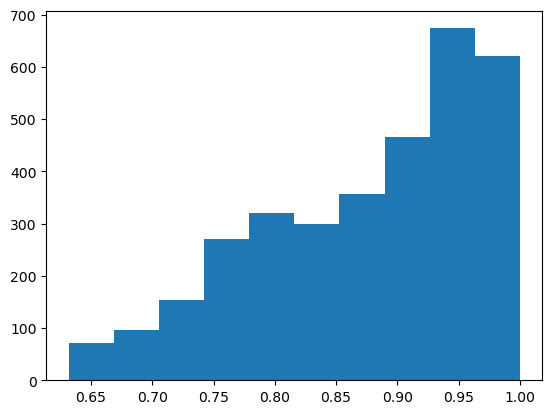

In [7]:
x = np.zeros(V)
for v_ind in range(V):
    x[v_ind] = np.dot(point - v[v_ind], normals[v_ind]) / np.linalg.norm(point - v[v_ind])
plt.hist(x)
plt.show()

In [8]:
p = mp.plot(v, f, c = x , return_plot=True)
p.add_points(np.array([X[0:3]]), f,  shading={"point_size": 5.0})
p


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(19.867670…

Invalid color array given! Supported are numpy arrays. <class 'numpy.ndarray'>
